This Notebook will find optimal wieghts using MPT, then will back test those wieghts 1 year fowrad from data collections

In [1]:
import time
import os 

start_time = time.time() # measure run time

WORKSPACE_DIR = os.getenv('WORKSPACE_DIR')
if not os.getcwd().endswith('portfolio_py'):
    os.chdir(f'{WORKSPACE_DIR}/portfolio_py')
print(f'Current Working Directory: {os.getcwd()}')


Current Working Directory: /Users/blakeuribe/Desktop/portfolio_py


Get Back Test Dates

In [2]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
from utils.config import PROGRAM_START_DATE, PROGRAM_END_DATE, mpt_stocks_for_profit, mpt_stocks_for_sharpe
from utils.finance_utils import backtest_portfolio, MPTOptimizer

date_obj = datetime.strptime(PROGRAM_END_DATE, "%Y-%m-%d")  # Convert string to datetime objectb
backtest_end = date_obj + relativedelta(years=1)

backtest_start = PROGRAM_END_DATE


Updated on 02/10/2025 8:54

---------------------------------
finance_utils.py successfully loaded, updated last Feb. 17 2025 1:43
---------------------------------




Conduct MPT

--MPT on High Profit--


[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


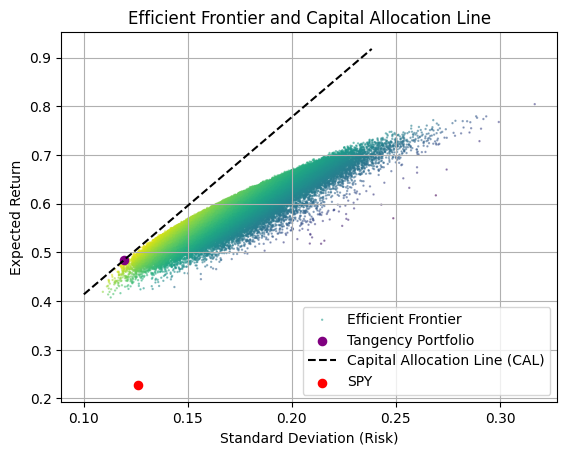

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

-- Optimal Portfolio (CAL) --
Max Sharpe Ratio: 3.64
Corresponding Return: 0.48
Corresponding Standard Deviation: 0.12
Optimal Weights: {'NVDA': np.float64(0.08471858051717214), 'TCOM': np.float64(0.24674473218593101), 'MO': np.float64(0.30537188479795063), 'MPLX': np.float64(0.10215392753287145), 'NFLX': np.float64(0.06940878246348879), 'ISRG': np.float64(0.10859123504492571), 'NWG': np.float64(0.02877683271528629), 'SYF': np.float64(0.054234024742373974)}

--MPT on High Sharpe--


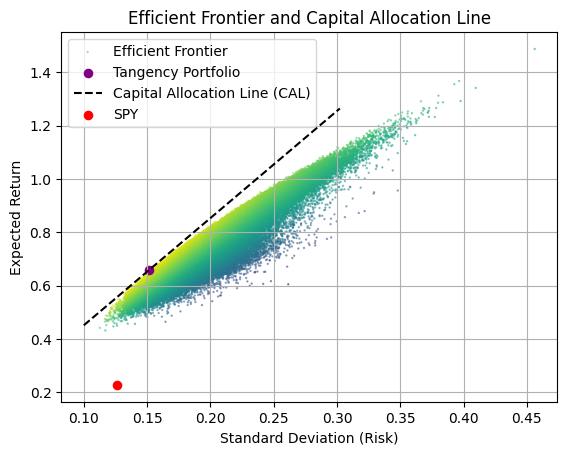

-- Optimal Portfolio (CAL) --
Max Sharpe Ratio: 4.02
Corresponding Return: 0.66
Corresponding Standard Deviation: 0.15
Optimal Weights: {'NVDA': np.float64(0.09938613210161877), 'TCOM': np.float64(0.07205892969925494), 'MO': np.float64(0.30599094581926034), 'APP': np.float64(0.1681265120583081), 'MPLX': np.float64(0.03873241527396184), 'NFLX': np.float64(0.06782747493115951), 'ISRG': np.float64(0.1864776849012903), 'NWG': np.float64(0.06139990521514625)}


In [3]:
print('--MPT on High Profit--')
optimizer_for_high_profit = MPTOptimizer(mpt_stocks_for_profit, start_date=PROGRAM_START_DATE, end_date=PROGRAM_END_DATE)
optimizer_for_high_profit.simulate_portfolios()
optimizer_for_high_profit.plot_efficient_frontier()
tangecy_portfolio_for_profit_stocks = optimizer_for_high_profit.find_tangency_portfolio()

print('\n--MPT on High Sharpe--')
optimizer_for_high_sharpe = MPTOptimizer(mpt_stocks_for_sharpe, start_date=PROGRAM_START_DATE, end_date=PROGRAM_END_DATE)
optimizer_for_high_sharpe.simulate_portfolios()
optimizer_for_high_sharpe.plot_efficient_frontier()
tangecy_portfolio_for_sharpe_stocks = optimizer_for_high_sharpe.find_tangency_portfolio()


In [19]:
tangecy_portfolio_for_sharpe_stocks[1]['Max Sharpe']

np.float64(4.020810492230133)

In [13]:
from utils.finance_utils import find_lending_or_borrowing_portfolio

# Benchmark Metrics
spy_return = optimizer_for_high_profit.spy_return.iloc[0]
spy_std = optimizer_for_high_profit.spy_std.iloc[0]
risk_free_rate = optimizer_for_high_profit.risk_free_rate.iloc[0] # Optimizer uses mean rate

# Info for high profit stocks
stock_weight_dict_profit = tangecy_portfolio_for_profit_stocks[0]
tangecy_portfolio_metrics_dict_profit = tangecy_portfolio_for_profit_stocks[1]

# Info for high profit stocks
stock_weight_dict_sharpe = tangecy_portfolio_for_sharpe_stocks[0]
tangecy_portfolio_metrics_dict_sharpe = tangecy_portfolio_for_sharpe_stocks[1]


# Find lending or borrowing for 
portfolio_allocation_high_profit = find_lending_or_borrowing_portfolio(
    tangecy_portfolio_metrics_dict_profit['Corresponding Return'],
    tangecy_portfolio_metrics_dict_profit['Corresponding Standard Deviation'],
    risk_free_rate,
    spy_std,
    list(stock_weight_dict_profit.keys()),
    list(stock_weight_dict_profit.values()),
    add_margin=True
    )

portfolio_allocation_high_sharpe = find_lending_or_borrowing_portfolio(
    tangecy_portfolio_metrics_dict_sharpe['Corresponding Return'],
    tangecy_portfolio_metrics_dict_sharpe['Corresponding Standard Deviation'],
    risk_free_rate,
    spy_std,
    list(stock_weight_dict_sharpe.keys()),
    list(stock_weight_dict_sharpe.values()),
    add_margin=True
    )

portfolio_allocation_high_sharpe

{'Risky Asset Weight': np.float64(0.8332725100628149),
 'Risk-Free Asset Weight': np.float64(0.1667274899371851),
 'Stocks': ['NVDA',
  'TCOM',
  'MO',
  'APP',
  'MPLX',
  'NFLX',
  'ISRG',
  'NWG',
  'SGOV'],
 'Stock Weights': array([0.08281573, 0.06004473, 0.25497384, 0.1400952 , 0.03227466,
        0.05651877, 0.15538673, 0.05116285, 0.16672749]),
 'Expected Portfolio Return': np.float64(0.5558906135282967),
 'Expected Portfolio Standard Deviation': np.float64(0.12593185248694505),
 'Note': 'Portfolio includes T-bills (expected std > benchmark std).'}

Begin Back Testing

In [14]:
print('----Begining Back Test----')
print(f'Back Test starts on: {backtest_start}')
print(f'Back Test ends on: {backtest_end}')

paper_value = 100_000


# Run the backtest
backtest_on_high_profit = backtest_portfolio(portfolio_allocation_high_profit['Stocks'], paper_value, portfolio_allocation_high_profit['Stock Weights'], start_date=backtest_start, end_date=backtest_end)
backtest_on_high_sharpe = backtest_portfolio(portfolio_allocation_high_sharpe['Stocks'], paper_value, portfolio_allocation_high_sharpe['Stock Weights'], start_date=backtest_start, end_date=backtest_end)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

----Begining Back Test----
Back Test starts on: 2025-01-01
Back Test ends on: 2026-01-01 00:00:00



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

Record Results

In [ ]:
import pandas as pd
import os

# Define file path
file_path = f"{WORKSPACE_DIR}/portfolio_py/data/clean/backtest_results.csv"

# Check if file exists
if os.path.exists(file_path):
    # Load existing data
    backtest_df = pd.read_csv(file_path)
else:
    # Create a new DataFrame if the file doesn't exist
    backtest_df = pd.DataFrame(columns=[
        "Data_Collection_Start", "Data_Collection_End",
        "Backtest_Start", "Backtest_End",
        "Stock_Selection_Method", 'Stocks', 'Sharpe', "Starting_Value", "Ending_Value"
    ])

# New entries to append
new_entries = [
    {
        "Data_Collection_Start": PROGRAM_START_DATE,
        "Data_Collection_End": PROGRAM_END_DATE,
        "Backtest_Start": backtest_start,
        "Backtest_End": backtest_end,
        "Stock_Selection_Method": "High Profit Stocks",
        "Stocks": (",".join(portfolio_allocation_high_profit['Stocks'])),
        'Sharpe': tangecy_portfolio_for_profit_stocks[1]['Max Sharpe']
        "Starting_Value": paper_value,
        "Ending_Value": backtest_on_high_profit
    },
    {
        "Data_Collection_Start": PROGRAM_START_DATE,
        "Data_Collection_End": PROGRAM_END_DATE,
        "Backtest_Start": backtest_start,
        "Backtest_End": backtest_end,
        "Stock_Selection_Method": "High Sharpe Ratio Stocks",
        "Stocks": (",".join(portfolio_allocation_high_sharpe['Stocks'])),
        'Sharpe': tangecy_portfolio_for_sharpe_stocks[1]['Max Sharpe']
        "Starting_Value": paper_value,
        "Ending_Value": backtest_on_high_sharpe
    }
]

# Convert new entries to a DataFrame
new_entries_df = pd.DataFrame(new_entries)

# Drop duplicates before writing
backtest_df = pd.concat([backtest_df, new_entries_df], ignore_index=True).drop_duplicates()

# **Append** to the CSV without overwriting
backtest_df.to_csv(file_path, index=False, mode="w")  

print("New rows added successfully (without overwriting)!") 


New rows added successfully (without overwriting)!


/var/folders/cd/2yq8cm193ln9jmnq_z6wtxnw0000gn/T/ipykernel_25051/2219341544.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  backtest_df = pd.concat([backtest_df, new_entries_df], ignore_index=True).drop_duplicates()


Find benchamrk log returns, and std, and then create a portfolio where std is below benchmark, but return is greater than

Also possibly put in a bell curve of distrubution of losses, and confidence intervals

In [16]:
backtest_df

,Data_Collection_Start,Data_Collection_End,Backtest_Start,Backtest_End,Stock_Selection_Method,Stocks,Starting_Value,Ending_Value
0,2024-01-01,2025-01-01,2025-01-01,2026-01-01,High Profit Stocks,"NVDA,TCOM,MO,MPLX,NFLX,ISRG,NWG,SYF",100000,112369.733768
1,2024-01-01,2025-01-01,2025-01-01,2026-01-01,High Sharpe Ratio Stocks,"NVDA,TCOM,MO,APP,MPLX,NFLX,ISRG,NWG,SGOV",100000,111743.977347
